In [1]:
import pandas as pd
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.calibration import calibration_curve

pd.set_option('display.max_columns', None)

In [12]:
data = pd.read_parquet("/Users/abubakr/zypl/scoring_rnd_my/Quara_new/data/jarir_train_anonim_files.parquet")
print(data.shape)
data.head(3)

(41439, 18)


,new_disb_date,nationality,age,ca_province,ca_city,ce_sector,cc_gender,ca_residential_status,basic_wage,total_allowance,housing_allowance,svr_jdg_count,svr_jdg_monthsincelastsettld,svr_defaultamount,days_in_stage,simah_score,requested_loan_amount,target
0,2024-01-01,saudi_arabia,24,riyadh_region,al_majmaah,gov_military,m,with_the_parent,3480.0,5270.0,NaN,1.0,53.0,640.0,12.0,508,4199.0,0
1,2024-01-01,yemeni,27,jazan_region,sabya,nonsaudi_privt,m,with_the_parent,6000.0,0.0,0.0,0.0,0.0,0.0,439.0,619,30000.0,1
2,2024-01-01,saudi_arabia,39,asir_region,aseer,gov_military,m,with_the_parent,6760.0,4780.0,NaN,0.0,0.0,1207.5,6879.0,622,6699.0,0


In [ ]:
feature_list = ['nationality', 'age', 'ce_sector', 'cc_gender', "simah_score", "requested_loan_amount",
                'basic_wage', 'total_allowance', 'housing_allowance', 'svr_jdg_count', 'svr_jdg_monthsincelastsettld',
                'svr_defaultamount', 'days_in_stage']

cat_feature_list = ['nationality', 'ce_sector', 'cc_gender']

In [14]:
data_for_modeling = data.copy()

default_rate = data_for_modeling['target'].mean()
print(f"Default Rate: {default_rate*100:.2f}%")


X = data_for_modeling[feature_list]
y = data_for_modeling['target']

X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train = X_train_full
X_test = X_test_full

Default Rate: 5.90%


In [15]:
params = {
    'bootstrap_type': 'MVS',
    'boosting_type': 'Plain',
    'depth': 5,
    'n_estimators': 811,
    'l2_leaf_reg': 9.186264916007664,
    'learning_rate': 0.05910923340789395,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False,
}

model = CatBoostClassifier(**params)

model.fit(
    X_train, y_train,
    cat_features=cat_feature_list,
    eval_set=(X_test, y_test)
)

y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_pred_proba_train)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"\n--- AUC Results ---")
print(f"Train AUC: {auc_train:.4f}")
print(f"Test AUC: {auc_test:.4f}")
print("-------------------")


--- AUC Results ---
Train AUC: 0.8698
Test AUC: 0.8483
-------------------



--- CatBoost Native Feature Importance (Prettified Output) ---


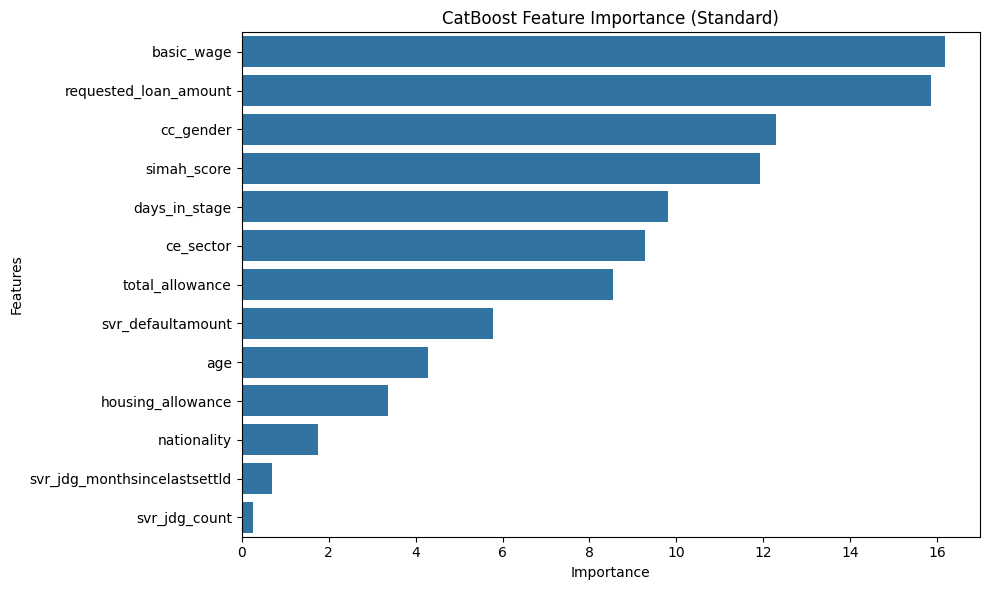



--- SHAP Feature Importance Summary Plot (Global - Dot Plot) ---


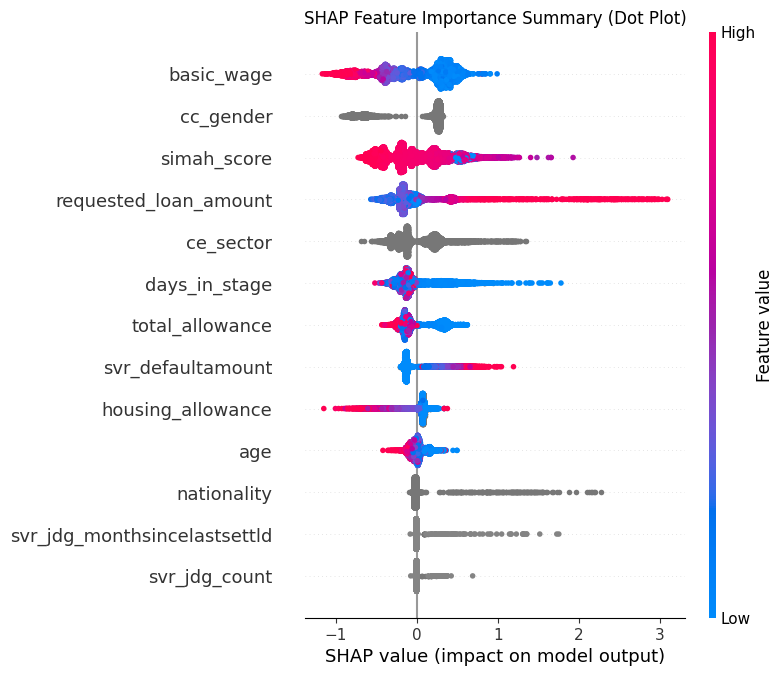

In [16]:
import matplotlib.pyplot as plt
import shap
import numpy as np
import seaborn as sns
from catboost import Pool

print("\n--- CatBoost Native Feature Importance (Prettified Output) ---")

feature_importance = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_feature_list))
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = X_train.columns[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.title('CatBoost Feature Importance (Standard)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
print("")

print("\n--- SHAP Feature Importance Summary Plot (Global - Dot Plot) ---")

try:
    shap.initjs()
except:
    pass

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance Summary (Dot Plot)")
plt.show()
print("")


--- Plotting PD Distribution ---


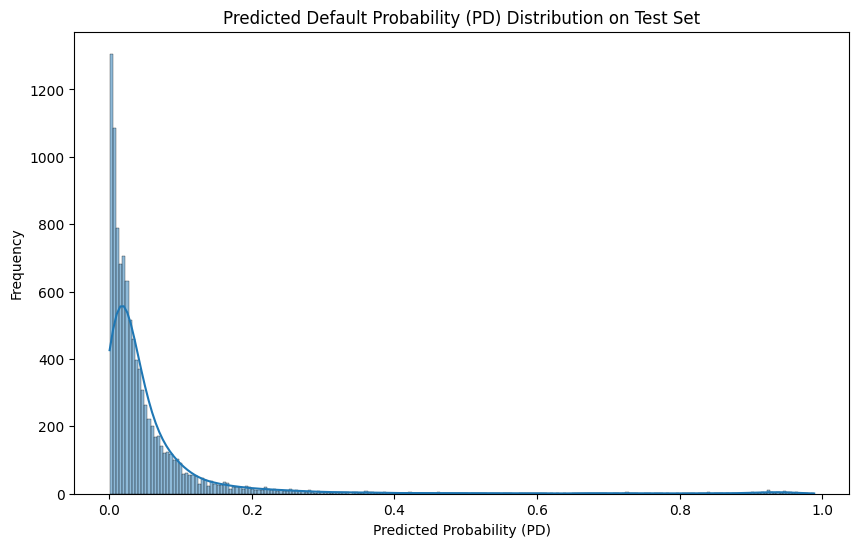

In [17]:
print("\n--- Plotting PD Distribution ---")
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba_test, kde=True)
plt.title('Predicted Default Probability (PD) Distribution on Test Set')
plt.xlabel('Predicted Probability (PD)')
plt.ylabel('Frequency')
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

print("\n--- Cross-Validation AUC Scores ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_auc_scores = []
val_auc_scores = []
X_cv = X

for fold, (train_index, val_index) in enumerate(cv.split(X_cv, y)):
    X_train_cv, X_val_cv = X_cv.iloc[train_index], X_cv.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = CatBoostClassifier(**params)

    model_cv.fit(
        X_train_cv, y_train_cv,
        cat_features=cat_feature_list,
        verbose=0
    )

    y_pred_train = model_cv.predict_proba(X_train_cv)[:, 1]
    y_pred_val = model_cv.predict_proba(X_val_cv)[:, 1]

    auc_train = roc_auc_score(y_train_cv, y_pred_train)
    auc_val = roc_auc_score(y_val_cv, y_pred_val)

    train_auc_scores.append(auc_train)
    val_auc_scores.append(auc_val)

    print(f"Fold {fold+1}: Train AUC: {auc_train:.4f}, Test AUC: {auc_val:.4f}")

train_mean = np.mean(train_auc_scores)
train_std = np.std(train_auc_scores)
val_mean = np.mean(val_auc_scores)
val_std = np.std(val_auc_scores)

cv_results = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(val_auc_scores))] + ['Mean', 'Std'],
    'Train AUC': [f'{score:.4f}' for score in train_auc_scores] + [f'{train_mean:.4f}', f'{train_std:.4f}'],
    'Test AUC': [f'{score:.4f}' for score in val_auc_scores] + [f'{val_mean:.4f}', f'{val_std:.4f}']
})

print("\n--- Cross-Validation Results Table ---")
cv_results


--- Cross-Validation AUC Scores ---
Fold 1: Train AUC: 0.8873, Test AUC: 0.8423
Fold 2: Train AUC: 0.8879, Test AUC: 0.8426
Fold 3: Train AUC: 0.8962, Test AUC: 0.8286
Fold 4: Train AUC: 0.8898, Test AUC: 0.8548
Fold 5: Train AUC: 0.8919, Test AUC: 0.8483

--- Cross-Validation Results Table ---


,Fold,Train AUC,Test AUC
0,Fold 1,0.8873,0.8423
1,Fold 2,0.8879,0.8426
2,Fold 3,0.8962,0.8286
3,Fold 4,0.8898,0.8548
4,Fold 5,0.8919,0.8483
5,Mean,0.8906,0.8433
6,Std,0.0032,0.0087



--- Plotting Calibration Curve ---


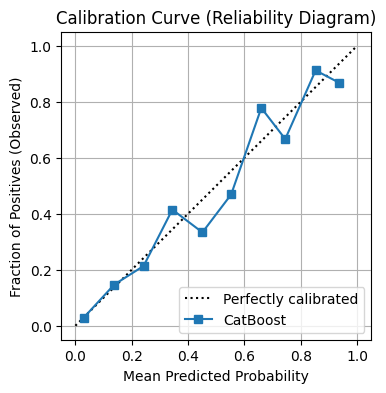

In [19]:
print("\n--- Plotting Calibration Curve ---")
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba_test, n_bins=10
)

plt.figure(figsize=(4, 4))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="CatBoost")
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Observed)')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print("")

In [20]:
df = data_for_modeling.copy()

from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, confusion_matrix, f1_score
)

def get_performance_metric(df: pd.DataFrame):
    train_set = df[df['is_train'] == 1].copy()
    test_set = df[df['is_train'] == 0].copy()
    target = 'target'

    model_threshold_list = []

    general_info = {
        'Samples': train_set.shape[0] + test_set.shape[0],
        'Train size': train_set.shape[0],
        'Test size': test_set.shape[0],
        'Total good': train_set[target].value_counts()[0] + test_set[target].value_counts()[0],
        'Total bad': train_set[target].value_counts()[1] + test_set[target].value_counts()[1],
        'Train good': train_set[target].value_counts()[0],
        'Train bad': train_set[target].value_counts()[1],
        'Test good': test_set[target].value_counts()[0],
        'Test bad': test_set[target].value_counts()[1],
        'Train NPL': round(train_set[target].value_counts()[1] / train_set.shape[0], 4),
        'Test NPL': round(test_set[target].value_counts()[1] / test_set.shape[0], 4),
    }

    model_performance = {
        'Train ROC AUC': round(roc_auc_score(train_set[target], train_set['prediction']), 3),
        'Test ROC AUC': round(roc_auc_score(test_set[target], test_set['prediction']), 3),
        'Train Gini': round(2 * roc_auc_score(train_set[target], train_set['prediction']) - 1, 4),
        'Test Gini': round(2 * roc_auc_score(test_set[target], test_set['prediction']) - 1, 3),
        'Train PR AUC': round(average_precision_score(train_set[target], train_set['prediction']), 3),
        'Test PR AUC': round(average_precision_score(test_set[target], test_set['prediction']), 3),
    }

    for thres in [x / 100 for x in range(5, 31, 5)]:
        thres_metrics = dict()
        test_set['prediction_label'] = (test_set['prediction'] > thres).astype(int)

        thres_metrics['Threshold'] = thres
        thres_metrics['Accuracy'] = round(accuracy_score(test_set[target], test_set['prediction_label']), 3)

        tn, fp, fn, tp = confusion_matrix(test_set[target], test_set['prediction_label']).ravel()
        thres_metrics['Model NPL'] = round(fn / (tn + fn), 3)
        thres_metrics['Approval rate'] = round((fn + tn) / (tn + fp + fn + tp), 3)
        thres_metrics['Good found'] = round(tn / (fp + tn), 3)
        thres_metrics['Bad found'] = round(tp / (fn + tp), 3)

        model_threshold_list.append(thres_metrics)

    threshold_df = pd.DataFrame(model_threshold_list)
    display(threshold_df)
    display(pd.DataFrame([general_info]))
    display(pd.DataFrame([model_performance]))
    return threshold_df, general_info, model_performance

train_pred_proba = model.predict_proba(X_train)[:, 1]
test_pred_proba = model.predict_proba(X_test)[:, 1]

preds = pd.DataFrame({
    'prediction': np.concatenate([train_pred_proba, test_pred_proba]),
    'target': np.concatenate([y_train, y_test]),
    'is_train': np.concatenate([np.ones(len(y_train)), np.zeros(len(y_test))])
})

print('123')
threshold_df, general_info, model_performance = get_performance_metric(preds)

123


,Threshold,Accuracy,Model NPL,Approval rate,Good found,Bad found
0,0.05,0.736,0.019,0.703,0.733,0.773
1,0.10,0.881,0.028,0.872,0.900,0.581
2,0.15,0.921,0.033,0.923,0.949,0.476
3,0.20,0.935,0.038,0.948,0.969,0.391
4,0.25,0.944,0.040,0.961,0.981,0.352
5,0.30,0.948,0.042,0.970,0.988,0.313


,Samples,Train size,Test size,Total good,Total bad,Train good,Train bad,Test good,Test bad,Train NPL,Test NPL
0,41439,31079,10360,38995,2444,29246,1833,9749,611,0.059,0.059


,Train ROC AUC,Test ROC AUC,Train Gini,Test Gini,Train PR AUC,Test PR AUC
0,0.87,0.848,0.7396,0.697,0.506,0.434


# Mapping

In [21]:
data = pd.read_parquet("/Users/abubakr/zypl/scoring_rnd_my/Quara_new/data/jarir_train_anonim_files.parquet")
print(data.shape)
data.head(3)

(41439, 18)


,new_disb_date,nationality,age,ca_province,ca_city,ce_sector,cc_gender,ca_residential_status,basic_wage,total_allowance,housing_allowance,svr_jdg_count,svr_jdg_monthsincelastsettld,svr_defaultamount,days_in_stage,simah_score,requested_loan_amount,target
0,2024-01-01,saudi_arabia,24,riyadh_region,al_majmaah,gov_military,m,with_the_parent,3480.0,5270.0,NaN,1.0,53.0,640.0,12.0,508,4199.0,0
1,2024-01-01,yemeni,27,jazan_region,sabya,nonsaudi_privt,m,with_the_parent,6000.0,0.0,0.0,0.0,0.0,0.0,439.0,619,30000.0,1
2,2024-01-01,saudi_arabia,39,asir_region,aseer,gov_military,m,with_the_parent,6760.0,4780.0,NaN,0.0,0.0,1207.5,6879.0,622,6699.0,0


In [ ]:
data = data.rename(columns={'ce_sector': 'sector', 'cc_gender':'Gender'})

data = data[~data['sector'].isin(['private_saudis', 'government_semi_government_saudis'])]

sector_mapping = {
    'nonsaudi_gov_nonmilitary': 'NONSAUDI_GOV-NONMILITARY',
    'nonsaudi_privt': 'NONSAUDI_PRIVT',
    'privt': 'PRIVT',
    'gov_nonmilitary': 'GOV-NONMILITARY',
    'gov_military': 'GOV-MILITARY',
    'retmt': 'RETMT',
    'private_saudis': 'NULL',  # not listed in SECTOR, mapped to NULL
    'government_semi_government_saudis': 'NULL'  # same here
}

data['sector'] = data['sector'].map(sector_mapping).fillna('NULL')
data.Gender = data.Gender.str.upper()
data = data.dropna(subset=['requested_loan_amount'])

feature_list = ['nationality', 'age', 'sector', 'Gender', "simah_score", "requested_loan_amount",
                'basic_wage', 'total_allowance', 'housing_allowance', 'svr_jdg_count', 'svr_jdg_monthsincelastsettld',
                'svr_defaultamount', 'days_in_stage']

cat_feature_list = ['nationality', 'sector', 'Gender']

print(data.duplicated(subset=data.drop(['new_disb_date'],axis=1).columns).sum())
print(data.shape)
data[feature_list].head(4)

1
(41322, 18)


,nationality,age,sector,Gender,simah_score,requested_loan_amount,basic_wage,total_allowance,housing_allowance,svr_jdg_count,svr_jdg_monthsincelastsettld,svr_defaultamount,days_in_stage
0,saudi_arabia,24,GOV-MILITARY,M,508,4199.0,3480.0,5270.0,NaN,1.0,53.0,640.00,12.0
1,yemeni,27,NONSAUDI_PRIVT,M,619,30000.0,6000.0,0.0,0.0,0.0,0.0,0.00,439.0
2,saudi_arabia,39,GOV-MILITARY,M,622,6699.0,6760.0,4780.0,NaN,0.0,0.0,1207.50,6879.0
3,saudi_arabia,47,GOV-NONMILITARY,M,584,5699.0,20170.0,700.0,NaN,0.0,0.0,572.03,9247.0


In [23]:
nationality_map = {
    'saudi_arabia': 'Kingdom of Saudi Arabia',
    'yemeni': 'Yemen',
    'pakistani': 'Pakistan',
    'egyptian': 'Egypt',
    'indian': 'INDIA',
    'bangladeshi': 'Bangladesh',
    'sudanese': 'Sudan',
    'jordanian': 'Jordan',
    'filipino': 'Philippines',
    'lebanese': 'Lebanon',
    'sri_lankan': 'Sri Lanka',
    'null_value': 'Others',
    'kuwaiti': 'Kuwait',
    'afghani': 'Afghanistan',
    'turkish': 'Turkey',
    'palestinian': 'Palestine',
    'ghanaian': 'Ghana',
    'moroccan': 'Morocco',
    'malian': 'Mali',
    'syrian': 'Syria',
    'eritrean': 'Eritrea',
    'tunisian': 'Tunisia',
    'cameroonian': 'Cameroon',
    'senegalese': 'Senegal',
    'somali': 'Somalia',
    'greek': 'Greece',
    'south_african': 'South Africa',
    'indonesian': 'Indonesia',
    'nigerian': 'Nigeria',
    'nepalese': 'Nepal',
    'nigerien': 'Niger',
    'ethiopian': 'Ethiopia',
    'french': 'France',
    'british': 'United Kingdom',
    'bahraini': 'Bahrain',
    'omani': 'Oman',
    'azerbaijani': 'Azerbaijan',
    'mauritanian': 'Mauritania',
    'malaysian': 'Malaysia',
    'chadian': 'Chad',
    'kyrgyz': 'Kyrgyz Republic',
    'russian': 'Russia',
    'others': 'Others',
    'venezuelan': 'Venezuela',
    'chinese': 'China',
    'dutch': 'Netherlands',
    'american': 'United States',
    'italian': 'Italy',
    'canadian': 'Canada'
}

data['nationality'] = data['nationality'].map(nationality_map)

In [24]:
data_for_modeling = data.copy()

default_rate = data_for_modeling['target'].mean()
print(f"Default Rate: {default_rate*100:.2f}%")

X = data_for_modeling[feature_list]
y = data_for_modeling['target']

X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train = X_train_full
X_test = X_test_full

Default Rate: 5.87%



--- AUC Results ---
Train AUC: 0.8699
Test AUC: 0.8439
-------------------

--- CatBoost Native Feature Importance (Prettified Output) ---


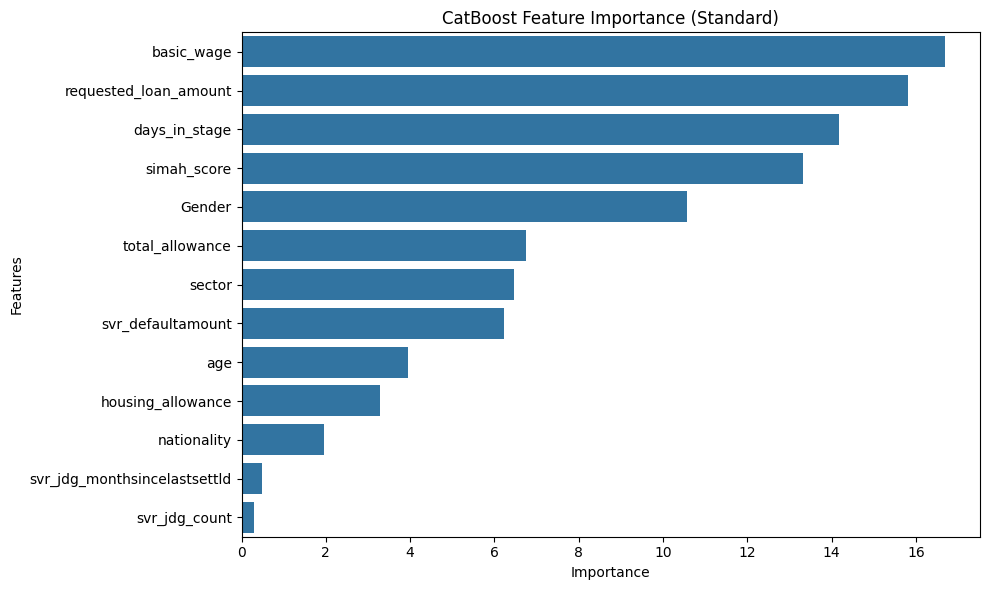



--- SHAP Feature Importance Summary Plot (Global - Dot Plot) ---


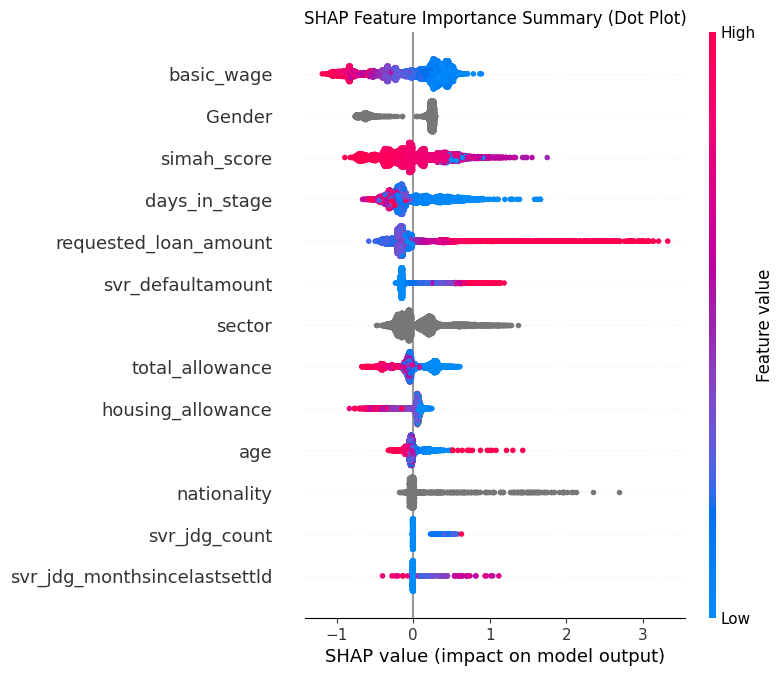

In [25]:
params = {
    'bootstrap_type': 'MVS',
    'boosting_type': 'Plain',
    'depth': 5,
    'n_estimators': 811,
    'l2_leaf_reg': 9.186264916007664,
    'learning_rate': 0.05910923340789395,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False,
}

model = CatBoostClassifier(**params)

model.fit(
    X_train, y_train,
    cat_features=cat_feature_list,
    eval_set=(X_test, y_test)
)

y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_pred_proba_train)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"\n--- AUC Results ---")
print(f"Train AUC: {auc_train:.4f}")
print(f"Test AUC: {auc_test:.4f}")
print("-------------------")

import matplotlib.pyplot as plt
import shap
import numpy as np
import seaborn as sns
from catboost import Pool

print("\n--- CatBoost Native Feature Importance (Prettified Output) ---")

feature_importance = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_feature_list))
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = X_train.columns[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.title('CatBoost Feature Importance (Standard)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
print("")

print("\n--- SHAP Feature Importance Summary Plot (Global - Dot Plot) ---")

try:
    shap.initjs()
except:
    pass

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance Summary (Dot Plot)")
plt.show()
print("")

In [26]:
df = data_for_modeling.copy()

from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, confusion_matrix, f1_score
)

def get_performance_metric(df: pd.DataFrame):
    train_set = df[df['is_train'] == 1].copy()
    test_set = df[df['is_train'] == 0].copy()
    target = 'target'

    model_threshold_list = []

    general_info = {
        'Samples': train_set.shape[0] + test_set.shape[0],
        'Train size': train_set.shape[0],
        'Test size': test_set.shape[0],
        'Total good': train_set[target].value_counts()[0] + test_set[target].value_counts()[0],
        'Total bad': train_set[target].value_counts()[1] + test_set[target].value_counts()[1],
        'Train good': train_set[target].value_counts()[0],
        'Train bad': train_set[target].value_counts()[1],
        'Test good': test_set[target].value_counts()[0],
        'Test bad': test_set[target].value_counts()[1],
        'Train NPL': round(train_set[target].value_counts()[1] / train_set.shape[0], 4),
        'Test NPL': round(test_set[target].value_counts()[1] / test_set.shape[0], 4),
    }

    model_performance = {
        'Train ROC AUC': round(roc_auc_score(train_set[target], train_set['prediction']), 3),
        'Test ROC AUC': round(roc_auc_score(test_set[target], test_set['prediction']), 3),
        'Train Gini': round(2 * roc_auc_score(train_set[target], train_set['prediction']) - 1, 4),
        'Test Gini': round(2 * roc_auc_score(test_set[target], test_set['prediction']) - 1, 3),
        'Train PR AUC': round(average_precision_score(train_set[target], train_set['prediction']), 3),
        'Test PR AUC': round(average_precision_score(test_set[target], test_set['prediction']), 3),
    }

    for thres in [x / 100 for x in range(5, 31, 5)]:
        thres_metrics = dict()
        test_set['prediction_label'] = (test_set['prediction'] > thres).astype(int)

        thres_metrics['Threshold'] = thres
        thres_metrics['Accuracy'] = round(accuracy_score(test_set[target], test_set['prediction_label']), 3)

        tn, fp, fn, tp = confusion_matrix(test_set[target], test_set['prediction_label']).ravel()
        thres_metrics['Model NPL'] = round(fn / (tn + fn), 3)
        thres_metrics['Approval rate'] = round((fn + tn) / (tn + fp + fn + tp), 3)
        thres_metrics['Good found'] = round(tn / (fp + tn), 3)
        thres_metrics['Bad found'] = round(tp / (fn + tp), 3)

        model_threshold_list.append(thres_metrics)

    threshold_df = pd.DataFrame(model_threshold_list)
    display(threshold_df)
    display(pd.DataFrame([general_info]))
    display(pd.DataFrame([model_performance]))
    return threshold_df, general_info, model_performance

train_pred_proba = model.predict_proba(X_train)[:, 1]
test_pred_proba = model.predict_proba(X_test)[:, 1]

preds = pd.DataFrame({
    'prediction': np.concatenate([train_pred_proba, test_pred_proba]),
    'target': np.concatenate([y_train, y_test]),
    'is_train': np.concatenate([np.ones(len(y_train)), np.zeros(len(y_test))])
})
print('123')
threshold_df, general_info, model_performance = get_performance_metric(preds)
print(get_performance_metric(preds))

123


,Threshold,Accuracy,Model NPL,Approval rate,Good found,Bad found
0,0.05,0.731,0.019,0.699,0.728,0.774
1,0.10,0.884,0.028,0.874,0.903,0.586
2,0.15,0.928,0.035,0.936,0.959,0.436
3,0.20,0.942,0.039,0.958,0.978,0.368
4,0.25,0.946,0.042,0.969,0.986,0.304
5,0.30,0.950,0.044,0.976,0.992,0.272


,Samples,Train size,Test size,Total good,Total bad,Train good,Train bad,Test good,Test bad,Train NPL,Test NPL
0,41322,30991,10331,38898,2424,29173,1818,9725,606,0.0587,0.0587


,Train ROC AUC,Test ROC AUC,Train Gini,Test Gini,Train PR AUC,Test PR AUC
0,0.87,0.844,0.7398,0.688,0.504,0.437


,Threshold,Accuracy,Model NPL,Approval rate,Good found,Bad found
0,0.05,0.731,0.019,0.699,0.728,0.774
1,0.10,0.884,0.028,0.874,0.903,0.586
2,0.15,0.928,0.035,0.936,0.959,0.436
3,0.20,0.942,0.039,0.958,0.978,0.368
4,0.25,0.946,0.042,0.969,0.986,0.304
5,0.30,0.950,0.044,0.976,0.992,0.272


,Samples,Train size,Test size,Total good,Total bad,Train good,Train bad,Test good,Test bad,Train NPL,Test NPL
0,41322,30991,10331,38898,2424,29173,1818,9725,606,0.0587,0.0587


,Train ROC AUC,Test ROC AUC,Train Gini,Test Gini,Train PR AUC,Test PR AUC
0,0.87,0.844,0.7398,0.688,0.504,0.437


(   Threshold  Accuracy  Model NPL  Approval rate  Good found  Bad found
0       0.05     0.731      0.019          0.699       0.728      0.774
1       0.10     0.884      0.028          0.874       0.903      0.586
2       0.15     0.928      0.035          0.936       0.959      0.436
3       0.20     0.942      0.039          0.958       0.978      0.368
4       0.25     0.946      0.042          0.969       0.986      0.304
5       0.30     0.950      0.044          0.976       0.992      0.272, {'Samples': 41322, 'Train size': 30991, 'Test size': 10331, 'Total good': 38898, 'Total bad': 2424, 'Train good': 29173, 'Train bad': 1818, 'Test good': 9725, 'Test bad': 606, 'Train NPL': 0.0587, 'Test NPL': 0.0587}, {'Train ROC AUC': 0.87, 'Test ROC AUC': 0.844, 'Train Gini': 0.7398, 'Test Gini': 0.688, 'Train PR AUC': 0.504, 'Test PR AUC': 0.437})


In [ ]:
X_test['model_pred'] = model.predict_proba(X_test)[:, 1]

X_test.sample(100, random_state=42).to_excel("../data/jarir_sample101.xlsx", index=False)

In [ ]:
X_test['model_pred'] = model.predict_proba(X_test)[:, 1]

X_test.sample(100, random_state=42).to_excel("../data/jarir_sample101.xlsx", index=False)

import joblib

explainer = shap.TreeExplainer(model)
joblib.dump(explainer, filename='../data/jarir_explainer.bz2', compress=("bz2", 9))

import json

validator = {"title":"jarir", "type":"object", "properties":{}, "required":[]}

for col in data[model.feature_names_]:
    col_dtype = str(data[col].dtype)
    if col in cat_feature_list:
        choices = {
            "enum": [str(x) if isinstance(x, np.integer) else x for x in data[col].unique()],
            "type": "string"
        }
        validator["properties"][col] = choices
    elif col_dtype == "int64" or col_dtype == "float64":
        validator["properties"][col] = {
            "type": "number",
            "minimum": None,
            "maximum": None,
        }
    else:
        raise ValueError(f"Validator failed to generate, failed on column: {col}, {col_dtype}")

    validator["required"].append(col)

with open(f"../data/jarir_validator.json", "w") as file:
    file.write(json.dumps(validator, indent=4))

import pickle

filename = '../data/jarir_model_v3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [29]:
import json
from enum import Enum

with open("../data/jarir_validator.json", "r", encoding="utf-8") as f:
    schema = json.load(f)

def to_pascal_case_two_letters(snake_str):
    parts = snake_str.split('_')
    pascal = ''.join([p.capitalize() for p in parts])
    if len(pascal) >= 2:
        return pascal[:2].upper() + pascal[2:]
    return pascal.upper()

def sanitize_enum_member(value):
    if value[0].isdigit():
        return f"_{value}"
    return value.lower()

def generate_enums_from_schema(schema):
    enums_code = []
    properties = schema.get("properties", {})
    for field_name, field_info in properties.items():
        if "enum" in field_info:
            class_name = to_pascal_case_two_letters(field_name)
            values = field_info["enum"]
            enum_members = "\n    ".join([f'{sanitize_enum_member(v)} = "{v}"' for v in values])
            enum_code = f"class {class_name}(str, Enum):\n    {enum_members}\n"
            enums_code.append(enum_code)
    return "\n\n".join(enums_code)

all_enums_code = generate_enums_from_schema(schema)

with open("generated_enums.py", "w", encoding="utf-8") as f:
    f.write(all_enums_code)

print(all_enums_code)

class NAtionality(str, Enum):
    kingdom of saudi arabia = "Kingdom of Saudi Arabia"
    yemen = "Yemen"
    pakistan = "Pakistan"
    egypt = "Egypt"
    india = "INDIA"
    bangladesh = "Bangladesh"
    sudan = "Sudan"
    jordan = "Jordan"
    philippines = "Philippines"
    lebanon = "Lebanon"
    sri lanka = "Sri Lanka"
    others = "Others"
    kuwait = "Kuwait"
    afghanistan = "Afghanistan"
    turkey = "Turkey"
    palestine = "Palestine"
    ghana = "Ghana"
    morocco = "Morocco"
    mali = "Mali"
    syria = "Syria"
    eritrea = "Eritrea"
    tunisia = "Tunisia"
    cameroon = "Cameroon"
    senegal = "Senegal"
    somalia = "Somalia"
    greece = "Greece"
    south africa = "South Africa"
    indonesia = "Indonesia"
    nigeria = "Nigeria"
    nepal = "Nepal"
    niger = "Niger"
    ethiopia = "Ethiopia"
    france = "France"
    united kingdom = "United Kingdom"
    bahrain = "Bahrain"
    oman = "Oman"
    azerbaijan = "Azerbaijan"
    mauritania = "Mauritania"
    ma

In [30]:
model.feature_names_

['nationality',
 'age',
 'sector',
 'Gender',
 'simah_score',
 'requested_loan_amount',
 'basic_wage',
 'total_allowance',
 'housing_allowance',
 'svr_jdg_count',
 'svr_jdg_monthsincelastsettld',
 'svr_defaultamount',
 'days_in_stage']